In [1]:
import pandas as pd
import kagglehub
import pandas as pd
import numpy as np
import pandas as pd
import scipy.special
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")
train_data=pd.read_csv(path+"/fashion-mnist_test.csv")
test_data=pd.read_csv(path+"/fashion-mnist_train.csv")
data=pd.concat([train_data,test_data])

100%|██████████| 68.8M/68.8M [00:04<00:00, 18.0MB/s]

Extracting files...


The model

In [36]:
# ======================================================
# Preprocessing Module
# ======================================================
def preprocessing(data):

    #images are in form of vectors
    images = data.iloc[:, 1:]
    labels = data.iloc[:, 0]

    # Normalize pixel values to [0,1]
    images = images.astype('float32') / 255.0

    # Split into training (80%) and temporary (20%)
    train_images, temp_images, train_labels, temp_labels = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Split temporary into validation (10%) and test (10%)
    val_images, test_images, val_labels, test_labels = train_test_split(
        temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )

    # Convert labels to one-hot encoding (10 classes)
    train_labels = to_categorical(train_labels, num_classes=10)
    val_labels = to_categorical(val_labels, num_classes=10)
    test_labels = to_categorical(test_labels, num_classes=10)

    return train_images, val_images, test_images, train_labels, val_labels, test_labels

# ======================================================
# Neural Network Model
# ======================================================

# Hyperparameters & Network Architecture
hidden_layers = 5
input_dim = 784 # 28x28 images flattened
hidden_neurons = [128, 128, 128, 128, 128]
output_dim = 10

# For hidden layers, you can choose any activation among:
# "relu", "leaky_relu", "tanh", "gelu" : The output layer will always use "softmax".
activations = ['relu', 'relu', 'relu', 'relu', 'relu', 'softmax']

# Build list of layer dimensions: [input_dim, hidden1, hidden2, ..., output_dim]
layers_dims = [input_dim] + hidden_neurons + [output_dim]

# Initialize weights and biases
weights = []
biases = []
for i in range(len(layers_dims) - 1):
    # For hidden layers, we use He initialization if activation is ReLU/Leaky-ReLU (or similar)
    if i < len(activations) - 1 and activations[i].lower() in ['relu', 'leaky_relu']:
        W = np.random.randn(layers_dims[i+1], layers_dims[i]) * np.sqrt(2.0 / layers_dims[i])
    else:
        # For other activations or for the softmax layer, we can use Xavier initialization.
        W = np.random.randn(layers_dims[i+1], layers_dims[i]) * np.sqrt(1.0 / layers_dims[i])
    b = np.zeros((layers_dims[i+1], 1))
    weights.append(W)
    biases.append(b)

# ======================================================
# Activation Functions & Their Derivatives
# ======================================================
def activation(x, func="relu", alpha=0.01):
    func = func.lower()
    if func == "relu":
        return np.maximum(0, x)
    elif func == "leaky_relu":
        return np.where(x > 0, x, alpha * x)
    elif func == "tanh":
        return np.tanh(x)
    elif func == "gelu":
        return 0.5 * x * (1 + scipy.special.erf(x / np.sqrt(2)))
    elif func == "elu":
        return np.where(x > 0, x, alpha * (np.exp(x) - 1))
    elif func == "softmax":
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)
    else:
        raise ValueError("Unsupported activation function: " + func)

def activation_derivative(z, func="relu", alpha=0.01):
    func = func.lower()
    if func == "relu":
        return (z > 0).astype(float)
    elif func == "leaky_relu":
        return np.where(z > 0, 1.0, alpha)
    elif func == "tanh":
        return 1 - np.tanh(z)**2
    elif func == "gelu":
        return (0.5 * (1 + scipy.special.erf(z / np.sqrt(2))) +
                (z * np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)))
    elif func == "elu":
        return np.where(z > 0, 1.0, alpha * np.exp(z))
    else:
        raise ValueError("Unsupported activation function for derivative: " + func)

# ======================================================
# Forward Pass
# ======================================================
def forward(X, weights, biases, activation_config, dropout_rate, training=True):
    activations_list = [X]    # Input activation
    pre_activations_list = []
    dropout_masks = []        # Stores dropout masks (for backprop)

    A = X
    # Process hidden layers
    for i in range(len(weights) - 1):
        Z = np.dot(weights[i], A) + biases[i]
        pre_activations_list.append(Z)

        # Use the activation function specified in activation_config
        A = activation(Z, activation_config[i])

        # Apply dropout only during training
        if training and dropout_rate > 0:
            mask = (np.random.rand(*A.shape) >= dropout_rate).astype(float)
            A = A * mask / (1 - dropout_rate)  # Inverted dropout scaling
        else:
            mask = np.ones_like(A)

        dropout_masks.append(mask)  # Save mask for backpropagation
        activations_list.append(A)

    # Process output layer (softmax); no dropout here.
    Z = np.dot(weights[-1], A) + biases[-1]
    pre_activations_list.append(Z)
    A = activation(Z, "softmax")
    activations_list.append(A)

    # Add identity mask for the output layer (no dropout applied here)
    dropout_masks.append(np.ones_like(A))

    return A, activations_list, pre_activations_list, dropout_masks


# ======================================================
# Loss Function (Cross-Entropy)
# ======================================================
def CE_loss(y, y_pred):
    epsilon = 1e-12  # To avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = -np.sum(y * np.log(y_pred), axis=0)
    return np.mean(loss)

def loss(X, y, weights, biases, activations, dropout_rate):
    y_pred, _, _, _ = forward(X, weights, biases, activations, dropout_rate)
    return CE_loss(y, y_pred)

# ======================================================
# Backpropagation with Support for Different Activation Functions
# ======================================================
def backprop(weights, biases, X, y, learning_rate, activations, dropout_rate):
    """
    Performs a single step of backpropagation using mini-batch gradient descent.
    Supports different activation functions for each hidden layer.

    Assumes:
      - The output layer uses softmax activation with cross-entropy loss.
      - The global list "activations" holds the activation for each layer
        in the forward pass (the last element being "softmax").
      - The forward() function returns:
            y_pred, activations_list, pre_activations_list
    """
    m = X.shape[1]  # Number of examples in the mini-batch.
    # Forward pass
    y_pred, activations_list, pre_activations_list, dropout_masks = forward(X, weights, biases, activations, dropout_rate)

    # For softmax with cross-entropy, the gradient at the output layer:
    dA = y_pred - y  # shape: (output_dim, m)

    dW_list = []
    dB_list = []

    # Backpropagate through layers (from output to input)
    for i in reversed(range(len(weights))):
        A_prev = activations_list[i]
        # For the current layer, dZ is initially dA (for output, softmax derivative is already applied)
        dZ = dA
        # Compute gradients for weights and biases.
        dW = np.dot(dZ, A_prev.T) / m
        dB = np.sum(dZ, axis=1, keepdims=True) / m
        dW_list.insert(0, dW)
        dB_list.insert(0, dB)

        # Propagate error to previous layer (if not at input)
        if i != 0:
            dA = np.dot(weights[i].T, dZ)
            # Apply the same dropout mask used in forward for the i-th hidden layer.
            dA = dA * dropout_masks[i-1]
            # Use the derivative of the activation used in layer i.
            # The corresponding activation for layer i is activations[i-1] because:
            #   pre_activations_list[0] corresponds to layer 1 (first hidden layer) and uses activations[0]
            act_func = activations[i-1]
            dZ = dA * activation_derivative(pre_activations_list[i-1], func=act_func)
            dA = dZ

    # Update weights and biases
    for i in range(len(weights)):
        weights[i] -= learning_rate * dW_list[i]
        biases[i]  -= learning_rate * dB_list[i]

    return weights, biases

# prediction accuracy
def predict(X, weights, biases, activations, dropout_rate=0.0):
    y_pred, _, _, _ = forward(X.T, weights, biases, activations, dropout_rate=0.0, training=False)
    predictions = np.argmax(y_pred, axis=0)
    return predictions

# ======================================================
# Training Loop (Mini-Batch Gradient Descent)
# ======================================================
def train(X, y, X_val, y_val, weights, biases, activations, epochs=100, learning_rate=0.01, batch_size=128, dropout_rate=0.0):
    """
    Trains the model using mini-batch gradient descent.
    X shape: (features, number_of_examples)
    y shape: (classes, number_of_examples)
    """
    m = X.shape[1]  # Total number of training examples.
    for epoch in range(epochs):
        # Shuffle training data.
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        y_shuffled = y[:, permutation]

        # Process mini-batches.
        for i in range(0, m, batch_size):
            end = i + batch_size
            X_batch = X_shuffled[:, i:end]
            y_batch = y_shuffled[:, i:end]
            weights, biases = backprop(weights, biases, X_batch, y_batch, learning_rate, activations, dropout_rate)

        # Print loss every 10 epochs.
        if epoch % 10 == 0:
            current_loss = loss(X, y, weights, biases, activations, dropout_rate)

            predictions = predict(X_val, weights, biases, activations, dropout_rate)
            true_labels = np.argmax(y_val, axis=0)
            accuracy = np.mean(predictions == true_labels) * 100

            print(f"Epoch {epoch}, Loss: {current_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

    return weights, biases


Experimenting with different activation functions with gradually decreasing number of neurons in each layer.


Training with activation: relu
Epoch 0, Loss: 0.9025, Validation Accuracy: 66.37%
Epoch 10, Loss: 0.3938, Validation Accuracy: 86.34%
Epoch 20, Loss: 0.3361, Validation Accuracy: 87.59%
Epoch 30, Loss: 0.2927, Validation Accuracy: 88.49%
Epoch 40, Loss: 0.2710, Validation Accuracy: 88.47%
Epoch 50, Loss: 0.2411, Validation Accuracy: 89.30%
Epoch 60, Loss: 0.2313, Validation Accuracy: 88.61%
Epoch 70, Loss: 0.2284, Validation Accuracy: 88.47%
Epoch 80, Loss: 0.1819, Validation Accuracy: 89.17%
Epoch 90, Loss: 0.1842, Validation Accuracy: 89.06%
Final Test Accuracy with relu: 88.71%

Training with activation: leaky_relu
Epoch 0, Loss: 0.7594, Validation Accuracy: 73.71%
Epoch 10, Loss: 0.4973, Validation Accuracy: 81.26%
Epoch 20, Loss: 0.3289, Validation Accuracy: 87.20%
Epoch 30, Loss: 0.2975, Validation Accuracy: 88.24%
Epoch 40, Loss: 0.2982, Validation Accuracy: 87.47%
Epoch 50, Loss: 0.2618, Validation Accuracy: 87.87%
Epoch 60, Loss: 0.2655, Validation Accuracy: 86.99%
Epoch 70, 

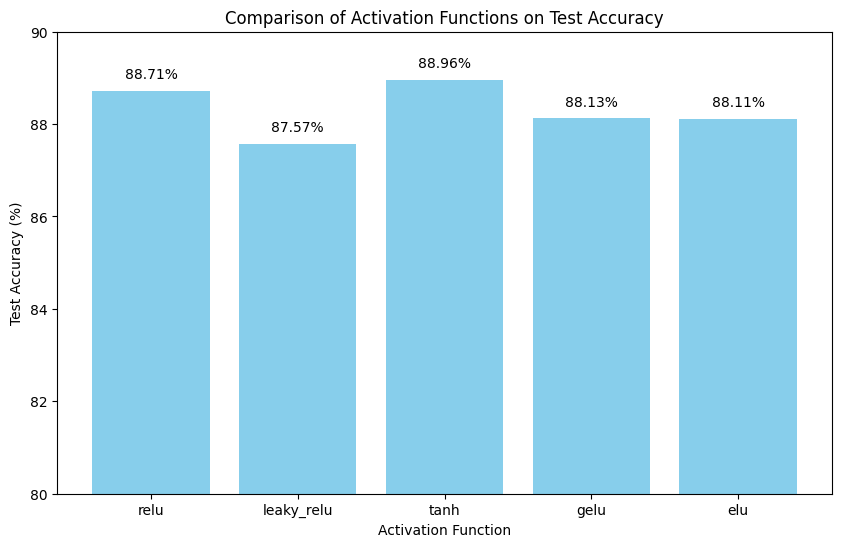

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Define activation functions to experiment with
activation_functions = ['relu', 'leaky_relu', 'tanh', 'gelu', 'elu']
hidden_layers = 5
input_dim = 784 # 28x28 images flattened
hidden_neurons = [128, 64, 64, 32, 32]
output_dim = 10

# Build list of layer dimensions: [input_dim, hidden1, hidden2, ..., output_dim]
layers_dims = [input_dim] + hidden_neurons + [output_dim]

# Store results for visualization
results = {}

train_images, val_images, test_images, train_labels, val_labels, test_labels = preprocessing(data)

X_train = train_images.to_numpy().T   # Now shape: (784, number_of_train_examples)
y_train = train_labels.T              # Now shape: (10, number_of_train_examples)
val_labels = val_labels.T
test_labels = test_labels.T

for activation_function in activation_functions:  # Changed 'activation' to 'activation_function'
    print(f"\nTraining with activation: {activation_function}")

    # Use the same activation for all hidden layers
    activations_list = [activation_function] * 5 # Changed 'activations' to 'activations_list'

    # Initialize weights and biases (reinitialize for each run)
    weights = []
    biases = []
    for i in range(len(layers_dims) - 1):
        if i < len(activations_list) - 1 and activations_list[i].lower() in ['relu', 'leaky_relu']:  # Use 'activations_list'
            W = np.random.randn(layers_dims[i + 1], layers_dims[i]) * np.sqrt(2.0 / layers_dims[i])
        else:
            W = np.random.randn(layers_dims[i + 1], layers_dims[i]) * np.sqrt(1.0 / layers_dims[i])
        b = np.zeros((layers_dims[i + 1], 1))
        weights.append(W)
        biases.append(b)

    # Train the model (use X_train, y_train, X_val, y_val for validation)
    trained_weights, trained_biases = train(X_train, y_train, val_images, val_labels, weights, biases, activations_list, epochs=100, learning_rate=0.01, batch_size=128)

    # Evaluate on test data
    predictions = predict(test_images, trained_weights, trained_biases, activations_list)
    true_labels = np.argmax(test_labels, axis=0)
    accuracy = accuracy_score(true_labels, predictions) * 100

    print(f"Final Test Accuracy with {activation_function}: {accuracy:.2f}%")  # Use 'activation_function'
    results[activation_function] = accuracy  # Use 'activation_function'

# Plot the activation function vs. accuracy
plt.figure(figsize=(10, 6))
bars = plt.bar(results.keys(), results.values(), color='skyblue')
plt.xlabel("Activation Function")
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of Activation Functions on Test Accuracy")
plt.ylim(80, 90)  # Set y-axis limits between 80 and 90

# Annotate each bar with the exact accuracy value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f"{yval:.2f}%", ha='center', va='bottom')

plt.show()


Experimenting with different dropouts


Training with dropout rate: 0
Epoch 0, Loss: 0.7631, Validation Accuracy: 70.41%
Epoch 10, Loss: 0.3472, Validation Accuracy: 86.64%
Epoch 20, Loss: 0.3080, Validation Accuracy: 87.74%
Epoch 30, Loss: 0.2699, Validation Accuracy: 88.64%
Epoch 40, Loss: 0.2529, Validation Accuracy: 88.47%
Epoch 50, Loss: 0.2226, Validation Accuracy: 89.01%
Epoch 60, Loss: 0.1895, Validation Accuracy: 89.21%
Epoch 70, Loss: 0.1932, Validation Accuracy: 89.17%
Epoch 80, Loss: 0.2006, Validation Accuracy: 88.46%
Epoch 90, Loss: 0.1775, Validation Accuracy: 88.81%
Final Test Accuracy with dropout rate 0: 88.41%

Training with dropout rate: 0.2
Epoch 0, Loss: 0.6103, Validation Accuracy: 77.93%
Epoch 10, Loss: 0.3748, Validation Accuracy: 86.16%
Epoch 20, Loss: 0.2937, Validation Accuracy: 88.46%
Epoch 30, Loss: 0.2664, Validation Accuracy: 88.37%
Epoch 40, Loss: 0.2713, Validation Accuracy: 87.87%
Epoch 50, Loss: 0.2184, Validation Accuracy: 88.76%
Epoch 60, Loss: 0.2015, Validation Accuracy: 88.79%
Epoch 

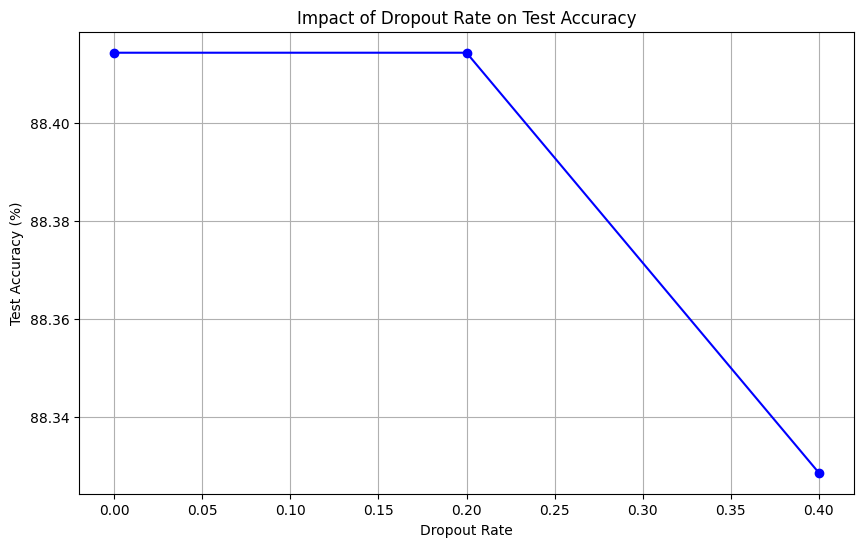

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Experiment settings
dropout_rates = [0, 0.2, 0.4]  # Different dropout probabilities
num_layers = 5                 # Fixed number of layers
num_neurons = 128              # Fixed number of neurons per layer
activation_function = 'relu'            # Fixed activation for consistency
activations_list = [activation_function] * 5

# Store results for visualization
results = {}

train_images, val_images, test_images, train_labels, val_labels, test_labels = preprocessing(data)

X_train = train_images.to_numpy().T   # Now shape: (784, number_of_train_examples)
y_train = train_labels.T              # Now shape: (10, number_of_train_examples)
val_labels = val_labels.T
test_labels = test_labels.T

# Train and Evaluate Model for Each Dropout Rate
for dropout_rate in dropout_rates:
    print(f"\nTraining with dropout rate: {dropout_rate}")

    # Define network architecture
    hidden_neurons = [num_neurons] * num_layers
    layers_dims = [input_dim] + hidden_neurons + [output_dim]

    # Initialize weights and biases
    weights = []
    biases = []
    for i in range(len(layers_dims) - 1):
        if activation_function in ['relu', 'leaky_relu']:
            W = np.random.randn(layers_dims[i + 1], layers_dims[i]) * np.sqrt(2.0 / layers_dims[i])
        else:
            W = np.random.randn(layers_dims[i + 1], layers_dims[i]) * np.sqrt(1.0 / layers_dims[i])
        b = np.zeros((layers_dims[i + 1], 1))
        weights.append(W)
        biases.append(b)

    # Train the model with dropout
    trained_weights, trained_biases = train(X_train, y_train, val_images, val_labels, weights, biases, activations_list, epochs=100, learning_rate=0.01, batch_size=128)

    # Evaluate on test data
    predictions = predict(test_images, trained_weights, trained_biases, activations_list)
    true_labels = np.argmax(test_labels, axis=0)
    accuracy = accuracy_score(true_labels, predictions) * 100

    print(f"Final Test Accuracy with dropout rate {dropout_rate}: {accuracy:.2f}%")

    # Store results
    results[dropout_rate] = accuracy

# Plot dropout rate vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(results.keys(), results.values(), marker='o', linestyle='-', color='b')
plt.xlabel("Dropout Rate")
plt.ylabel("Test Accuracy (%)")
plt.title("Impact of Dropout Rate on Test Accuracy")
plt.grid(True)
plt.show()


Experimenting with number of layers and number of neurons in them


Training with 2 layers and 64 neurons per layer
Epoch 0, Loss: 0.7113, Validation Accuracy: 76.83%
Epoch 10, Loss: 0.4140, Validation Accuracy: 85.63%
Epoch 20, Loss: 0.3796, Validation Accuracy: 86.27%
Epoch 30, Loss: 0.3569, Validation Accuracy: 86.90%
Epoch 40, Loss: 0.3247, Validation Accuracy: 87.54%
Epoch 50, Loss: 0.3105, Validation Accuracy: 87.67%
Epoch 60, Loss: 0.3264, Validation Accuracy: 86.89%
Epoch 70, Loss: 0.2775, Validation Accuracy: 88.54%
Epoch 80, Loss: 0.2936, Validation Accuracy: 88.24%
Epoch 90, Loss: 0.2592, Validation Accuracy: 88.56%
Final Test Accuracy with 2 layers and 64 neurons: 88.20%

Training with 2 layers and 256 neurons per layer
Epoch 0, Loss: 0.6713, Validation Accuracy: 78.96%
Epoch 10, Loss: 0.4190, Validation Accuracy: 85.36%
Epoch 20, Loss: 0.3659, Validation Accuracy: 86.76%
Epoch 30, Loss: 0.3579, Validation Accuracy: 86.29%
Epoch 40, Loss: 0.3075, Validation Accuracy: 88.16%
Epoch 50, Loss: 0.3041, Validation Accuracy: 87.81%
Epoch 60, Loss

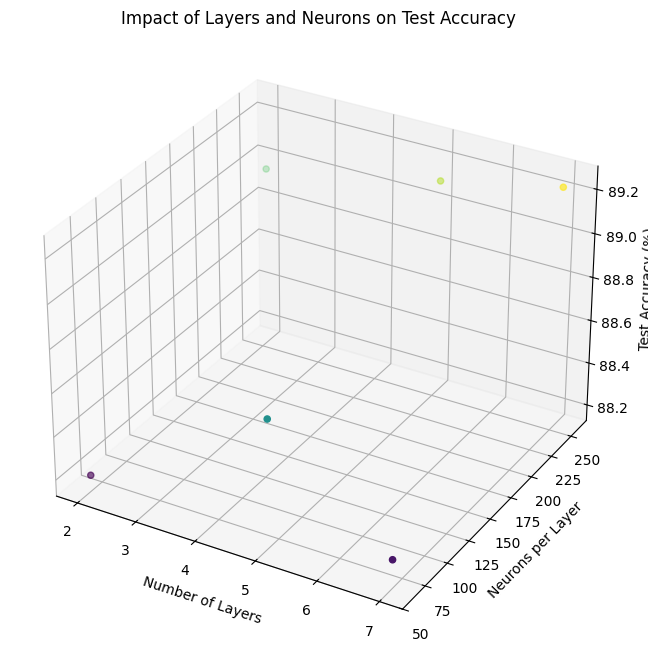

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import itertools

# Experiment settings
layer_configs = [2, 5, 7]                # Number of layers
neurons_per_layer = [64, 256]            # Number of neurons per layer
activation_function = 'relu'                      # Fixed activation for consistency

# Store results for visualization
results = {}

train_images, val_images, test_images, train_labels, val_labels, test_labels = preprocessing(data)

X_train = train_images.to_numpy().T   # Now shape: (784, number_of_train_examples)
y_train = train_labels.T              # Now shape: (10, number_of_train_examples)
val_labels = val_labels.T
test_labels = test_labels.T

# Loop over all combinations of layer counts and neurons
for num_layers, num_neurons in itertools.product(layer_configs, neurons_per_layer):
    print(f"\nTraining with {num_layers} layers and {num_neurons} neurons per layer")

    # Dynamically set the architecture
    hidden_neurons = [num_neurons] * num_layers
    layers_dims = [input_dim] + hidden_neurons + [output_dim]

    # Initialize weights and biases
    weights = []
    biases = []
    for i in range(len(layers_dims) - 1):
        # Use He initialization for ReLU and Leaky_ReLU
        if activation_function in ['relu', 'leaky_relu']:
            W = np.random.randn(layers_dims[i + 1], layers_dims[i]) * np.sqrt(2.0 / layers_dims[i])
        else:
            W = np.random.randn(layers_dims[i + 1], layers_dims[i]) * np.sqrt(1.0 / layers_dims[i])
        b = np.zeros((layers_dims[i + 1], 1))
        weights.append(W)
        biases.append(b)

    # Set the activation for all layers
    activations = [activation_function] * num_layers

    # Train the model
    trained_weights, trained_biases = train(X_train, y_train, val_images, val_labels, weights, biases, activations,
                                            epochs=100, learning_rate=0.01, batch_size=128)

    # Evaluate on test data
    predictions = predict(test_images, trained_weights, trained_biases, activations)
    true_labels = np.argmax(test_labels, axis=0)
    accuracy = accuracy_score(true_labels, predictions) * 100

    print(f"Final Test Accuracy with {num_layers} layers and {num_neurons} neurons: {accuracy:.2f}%")

    # Store results (num_layers, num_neurons) -> accuracy
    results[(num_layers, num_neurons)] = accuracy

# Visualize results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

layers = [x[0] for x in results.keys()]
neurons = [x[1] for x in results.keys()]
accuracies = list(results.values())

ax.scatter(layers, neurons, accuracies, c=accuracies, cmap='viridis', marker='o')

ax.set_xlabel('Number of Layers')
ax.set_ylabel('Neurons per Layer')
ax.set_zlabel('Test Accuracy (%)')
ax.set_title('Impact of Layers and Neurons on Test Accuracy')

plt.show()


Hyperparameters tuning considering all hyperparameters

In [40]:
import itertools
import numpy as np
import pandas as pd
import scipy.special
from sklearn.model_selection import train_test_split

# ==============================================================================
# Preprocessing Module
# ==============================================================================
def preprocessing(data):
    images = data.iloc[:, 1:]
    labels = data.iloc[:, 0]
    # Normalize pixel values to [0,1]
    images = images.astype('float32') / 255.0
    # Split into training (80%) and temporary (20%)
    train_images, temp_images, train_labels, temp_labels = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )
    # Split temporary into validation (10%) and test (10%)
    val_images, test_images, val_labels, test_labels = train_test_split(
        temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    # Convert labels to one-hot encoding (10 classes)
    from tensorflow.keras.utils import to_categorical
    train_labels = to_categorical(train_labels, num_classes=10)
    val_labels = to_categorical(val_labels, num_classes=10)
    test_labels = to_categorical(test_labels, num_classes=10)
    return train_images, val_images, test_images, train_labels, val_labels, test_labels

# ==============================================================================
# Activation Functions and Their Derivatives (with ELU included)
# ==============================================================================
def activation(x, func="relu", alpha=0.01):
    func = func.lower()
    if func == "relu":
        return np.maximum(0, x)
    elif func == "leaky_relu":
        return np.where(x > 0, x, alpha * x)
    elif func == "tanh":
        return np.tanh(x)
    elif func == "gelu":
        return 0.5 * x * (1 + scipy.special.erf(x / np.sqrt(2)))
    elif func == "elu":
        return np.where(x > 0, x, alpha * (np.exp(x) - 1))
    elif func == "softmax":
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)
    else:
        raise ValueError("Unsupported activation function: " + func)

def activation_derivative(z, func="relu", alpha=0.01):
    func = func.lower()
    if func == "relu":
        return (z > 0).astype(float)
    elif func == "leaky_relu":
        return np.where(z > 0, 1.0, alpha)
    elif func == "tanh":
        return 1 - np.tanh(z)**2
    elif func == "gelu":
        return (0.5 * (1 + scipy.special.erf(z / np.sqrt(2))) +
                (z * np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)))
    elif func == "elu":
        return np.where(z > 0, 1.0, alpha * np.exp(z))
    else:
        raise ValueError("Unsupported activation function for derivative: " + func)

# ==============================================================================
# Forward Pass with Dropout (now accepts activation_config)
# ==============================================================================
def forward(X, weights, biases, dropout_rate, activation_config):
    """
    Performs a forward pass through the network.
    Returns:
      - The final output (softmax probabilities)
      - A list of activations for each layer (including input)
      - A list of pre-activations (Z values) for each layer
      - A list of dropout masks for each hidden layer (for backprop)
    """
    activations_list = [X]    # Input activation
    pre_activations_list = []
    dropout_masks = []        # One mask per hidden layer

    A = X
    # Process hidden layers
    for i in range(len(weights) - 1):
        Z = np.dot(weights[i], A) + biases[i]
        pre_activations_list.append(Z)
        # Use the activation function specified in activation_config
        A = activation(Z, activation_config[i])
        # Apply dropout if dropout_rate > 0
        if dropout_rate > 0:
            mask = (np.random.rand(*A.shape) >= dropout_rate).astype(float)
            A = A * mask / (1 - dropout_rate)  # Inverted dropout scaling
        else:
            mask = np.ones_like(A)
        dropout_masks.append(mask)
        activations_list.append(A)
    # Process output layer (softmax); no dropout applied here.
    Z = np.dot(weights[-1], A) + biases[-1]
    pre_activations_list.append(Z)
    A = activation(Z, "softmax")
    activations_list.append(A)
    dropout_masks.append(np.ones_like(A))
    return A, activations_list, pre_activations_list, dropout_masks

# ==============================================================================
# Loss Function (Cross-Entropy)
# ==============================================================================
def CE_loss(y, y_pred):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    loss_val = -np.sum(y * np.log(y_pred), axis=0)
    return np.mean(loss_val)

def loss(X, y, weights, biases, dropout_rate, activation_config):
    y_pred, _, _, _ = forward(X, weights, biases, dropout_rate, activation_config)
    return CE_loss(y, y_pred)

# ==============================================================================
# Backpropagation with Dropout Support (now accepts activation_config)
# ==============================================================================
def backprop(weights, biases, X, y, learning_rate, dropout_rate, activation_config):
    """
    Performs one step of backpropagation using mini-batch gradient descent.
    Supports different activation functions and dropout.
    """
    m = X.shape[1]
    # Forward pass with dropout; get dropout masks.
    y_pred, activations_list, pre_activations_list, dropout_masks = forward(X, weights, biases, dropout_rate, activation_config)
    # For softmax with cross-entropy, gradient at output layer:
    dA = y_pred - y  # shape: (output_dim, m)

    dW_list = []
    dB_list = []

    # Loop backward through layers.
    for i in reversed(range(len(weights))):
        A_prev = activations_list[i]
        dZ = dA  # For output layer, softmax derivative is encapsulated in (y_pred - y)
        dW = np.dot(dZ, A_prev.T) / m
        dB = np.sum(dZ, axis=1, keepdims=True) / m
        dW_list.insert(0, dW)
        dB_list.insert(0, dB)
        if i != 0:
            dA = np.dot(weights[i].T, dZ)
            # Apply the same dropout mask used in forward for the i-th hidden layer.
            dA = dA * dropout_masks[i-1]
            act_func = activation_config[i-1]  # Use activation from our config for layer i
            dZ = dA * activation_derivative(pre_activations_list[i-1], func=act_func)
            dA = dZ
    # Update parameters
    for i in range(len(weights)):
        weights[i] -= learning_rate * dW_list[i]
        biases[i]  -= learning_rate * dB_list[i]
    return weights, biases

# ==============================================================================
# Training Loop with Dropout (now accepts activation_config)
# ==============================================================================
def train(X, y, weights, biases, epochs=100, learning_rate=0.001, batch_size=128, dropout_rate=0.0, activation_config=None):
    """
    Trains the model using mini-batch gradient descent.
    """
    if activation_config is None:
        raise ValueError("activation_config must be provided.")
    m = X.shape[1]
    for epoch in range(epochs):
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        y_shuffled = y[:, permutation]
        for i in range(0, m, batch_size):
            end = i + batch_size
            X_batch = X_shuffled[:, i:end]
            y_batch = y_shuffled[:, i:end]
            weights, biases = backprop(weights, biases, X_batch, y_batch, learning_rate, dropout_rate, activation_config)
        if epoch % 10 == 0:
            current_loss = loss(X, y, weights, biases, dropout_rate, activation_config)
            print(f"Epoch {epoch}, Loss: {current_loss:.4f}")
    return weights, biases

# ==============================================================================
# Function to Compute Accuracy
# ==============================================================================
def compute_accuracy(y, y_pred):
    # Ensure both arrays have shape (num_classes, num_examples)
    if y.shape[0] != y_pred.shape[0]:
        y = y.T
    pred_labels = np.argmax(y_pred, axis=0)
    true_labels = np.argmax(y, axis=0)
    return np.mean(pred_labels == true_labels)

# ==============================================================================
# Hyperparameter Search with Dropout Experimentation
# ==============================================================================

train_images, val_images, test_images, train_labels, val_labels, test_labels = preprocessing(data)

# Convert training images to a NumPy array and transpose:
X_train = train_images.to_numpy().T   # Now shape: (784, number_of_train_examples)
# Similarly, transpose one-hot encoded labels:
y_train = train_labels.T              # Now shape: (10, number_of_train_examples)

# Define hyperparameter options:
possible_hidden_layer_counts = [2, 5]
possible_neurons = [64,256]
activation_choices = ['relu', 'leaky_relu', 'gelu', 'elu']
learning_rates = [0.01]
batch_sizes = [128]
epochs_options = [80]
possible_dropout = [0.0, 0.2]

best_train_loss = float('inf')
best_config = None
results = []
input_dim = 784
output_dim = 10

# Hyperparameter search loop (only the relevant part is shown)
for num_hidden in possible_hidden_layer_counts:
    for neuron in possible_neurons:
        for act_choice in activation_choices:  # renamed loop variable
            # For all hidden layers, use the same activation; then output uses softmax
            activation_config = [act_choice] * num_hidden + ['softmax']
            # Define layer dimensions: hidden layers all have the same number of neurons
            layers_dims = [input_dim] + [neuron] * num_hidden + [output_dim]
            for dropout_rate in possible_dropout:
                for lr in learning_rates:
                    for bs in batch_sizes:
                        for epochs in epochs_options:
                            # Initialize weights and biases (same as before)
                            weights = []
                            biases = []
                            for i in range(len(layers_dims) - 1):
                                if i < num_hidden:  # hidden layers
                                    if act_choice.lower() in ['relu', 'leaky_relu']:
                                        W = np.random.randn(layers_dims[i+1], layers_dims[i]) * np.sqrt(2.0 / layers_dims[i])
                                    else:
                                        W = np.random.randn(layers_dims[i+1], layers_dims[i]) * np.sqrt(1.0 / layers_dims[i])
                                else:
                                    # For the output layer (softmax), use Xavier initialization:
                                    W = np.random.randn(layers_dims[i+1], layers_dims[i]) * np.sqrt(1.0 / layers_dims[i])
                                b = np.zeros((layers_dims[i+1], 1))
                                weights.append(W)
                                biases.append(b)

                            # Train the model
                            trained_weights, trained_biases = train(
                                X_train, y_train, weights, biases,
                                epochs=epochs, learning_rate=lr, batch_size=bs,
                                dropout_rate=dropout_rate, activation_config=activation_config
                            )

                            # Evaluate and record results ...


                            # Get final training loss
                            train_loss = loss(X_train, y_train, trained_weights, trained_biases, dropout_rate, activation_config)

                            # Evaluate on test set (assume test_images and test_labels are available)
                            X_test = test_images.to_numpy().T
                            y_test = test_labels.T
                            y_pred_test, _, _, _ = forward(X_test, trained_weights, trained_biases, dropout_rate=0.0, activation_config=activation_config)
                            test_acc = compute_accuracy(y_test, y_pred_test)

                            # Print and store configuration results
                            print("-------------------------------------------------")
                            print(f"Config: Hidden Layers = {num_hidden}, Neurons = {neuron}, Activation = {act_choice}")
                            print(f"Dropout = {dropout_rate}, LR = {lr}, Batch Size = {bs}, Epochs = {epochs}")
                            print(f"Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.4f}")

                            config_result = {
                                'hidden_layers': num_hidden,
                                'neurons': neuron,
                                'activation': act_choice,
                                'dropout': dropout_rate,
                                'lr': lr,
                                'batch_size': bs,
                                'epochs': epochs,
                                'train_loss': train_loss,
                                'test_accuracy': test_acc
                            }
                            results.append(config_result)
                            if train_loss < best_train_loss:
                                best_train_loss = train_loss
                                best_config = config_result

# Create a results table
results_df = pd.DataFrame(results)
print("=================================================")
print("Best configuration (by training loss):")
print(best_config)
print("=================================================")
print("All configurations and results:")
print(results_df)

Epoch 0, Loss: 0.7884
Epoch 10, Loss: 0.4355


KeyboardInterrupt: 

Plotting the results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_hyperparam_comparison(df):
    # Convert neurons tuple to string for plotting
    df['neurons_str'] = df['neurons'].astype(str)

    # Set y-axis limits according to your data (0.85 to 0.90 for decimals)
    y_min, y_max = 0.85, 0.90

    plt.figure(figsize=(14, 10))

    # 1) Activation comparison
    plt.subplot(2, 3, 1)
    sns.barplot(data=df, x='activation', y='test_accuracy', capsize=0.2)
    plt.ylim(y_min, y_max)
    plt.title("Accuracy by Activation")

    # 2) Dropout comparison
    plt.subplot(2, 3, 2)
    sns.barplot(data=df, x='dropout', y='test_accuracy', capsize=0.2)
    plt.ylim(y_min, y_max)
    plt.title("Accuracy by Dropout")

    # 3) Learning rate comparison
    plt.subplot(2, 3, 3)
    sns.barplot(data=df, x='lr', y='test_accuracy', capsize=0.2)
    plt.ylim(y_min, y_max)
    plt.title("Accuracy by Learning Rate")

    # 4) Neuron configuration comparison
    plt.subplot(2, 3, 4)
    sns.barplot(data=df, x='neurons_str', y='test_accuracy', capsize=0.2)
    plt.ylim(y_min, y_max)
    plt.xticks(rotation=45)
    plt.title("Accuracy by Neuron Configuration")

    # 5) Epochs comparison
    plt.subplot(2, 3, 5)
    sns.barplot(data=df, x='epochs', y='test_accuracy', capsize=0.2)
    plt.ylim(y_min, y_max)
    plt.title("Accuracy by Epochs")

    # 6) Hidden layers comparison (if applicable)
    if 'hidden_layers' in df.columns and df['hidden_layers'].nunique() > 1:
        plt.subplot(2, 3, 6)
        sns.barplot(data=df, x='hidden_layers', y='test_accuracy', capsize=0.2)
        plt.ylim(y_min, y_max)
        plt.title("Accuracy by Hidden Layers")

    plt.tight_layout()
    plt.show()


plot_hyperparam_comparison(results_df)